# Regridding CMIP6
##### Here we regrid a user defined cmip6 grid to anouther user defined target grid. For this we use `xESMF`, `intake-esm`, `dask`, and `xarray`.

In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import packages
import xarray as xr
import xesmf as xe
import intake
import util 
import pprint 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Define target grid
##### This is the grid that we will interpolate CMIP6 data to. 

In [5]:
cat = intake.Catalog('/glade/u/home/jhamman/hap_data.yaml')
target = cat['gmet_v2'].to_dask()
tgt_grid = xr.Dataset({'lat': (['lat'], target['lat']),
                     'lon': (['lon'], target['lon'])})

## Retrieve CMIP6 data
##### This data will be regridded to the target grid.

In [6]:
# Querry CMIP6 data catalog for desired data
cat = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
cat = cat.search(experiment_id = ['historical'], source_id = ['CESM2'], \
                 table_id = ['day'], variable_id = ['pr'], member_id = ['r2i1p1f1'])
cat.df.head()

# Create dataset
ds = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 10}})
ds = ds['CMIP.NCAR.CESM2.historical.day.gn']['pr']
ds = ds[0, 0:50, : , :] # This is to make the dataset small! 
ds.data

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


dask.array<getitem, shape=(50, 192, 288), dtype=float32, chunksize=(10, 192, 288), chunktype=numpy.ndarray>

## Regrid training to target

In [7]:
regridder = xe.Regridder(ds, tgt_grid, 'bilinear')
regridder.clean_weight_file()
regridded_ds = regridder(ds)
regridded_ds.data
regridded_ds = regridded_ds.compute() # Applied regridding (no longer lazy!)

Create weight file: bilinear_192x288_224x464.nc
Remove file bilinear_192x288_224x464.nc


## Plot Regrided Data

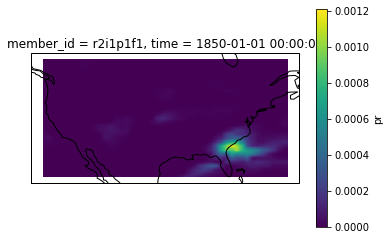

In [14]:
ax = plt.axes(projection=ccrs.PlateCarree())
regridded_ds.isel(time=0).plot.pcolormesh(ax=ax);
ax.coastlines();

## Plot Original data

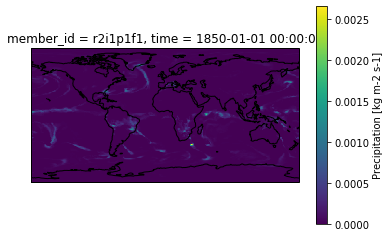

In [15]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds.isel(time=0).plot.pcolormesh(ax=ax);
ax.coastlines();